# <center>Searching in scientific papers</center>
##  <center>Patrik Kovács</center>
###  <center>Subject: Information retrieval </center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Used libraries

In [2]:
%pip install ijson==3.1.2

     |████████████████████████████████| 133kB 11.0MB/s 


In [3]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
import json
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#import ijson
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exploratory analysis


In [4]:
df=pd.read_json('/content/drive/My Drive/ING/VINF/papers.json',orient='records')

In [5]:
df.shape

(1765688, 14)

In [6]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,nan,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,nan,nan,nan,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'..."
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",nan,nan,nan,physics.gen-ph,nan,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[['Pan', 'Hongjun', '']]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,nan,nan,nan,math.CO,nan,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[['Callan', 'David', '']]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,nan,"Illinois J. Math. 52 (2008) no.2, 681-689",nan,nan,math.CA math.FA,nan,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ..."


## Categories


In [7]:
df['categories'].isnull().sum()

0

In [8]:
def categories_to_list_of_strings(categories):
    return str(categories.split(' '))

In [9]:
df['categories']=df['categories'].apply(categories_to_list_of_strings)

In [10]:
df['categories']=df['categories'].apply(eval)

In [11]:
type(df['categories'][0])

list

In [12]:
df['categories'].head()

0              [hep-ph]
1      [math.CO, cs.CG]
2      [physics.gen-ph]
3             [math.CO]
4    [math.CA, math.FA]
Name: categories, dtype: object

In [13]:
mlb = MultiLabelBinarizer()

In [14]:
mlb.fit_transform(df['categories'])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [15]:
mlb.classes_

array(['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph',
       'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE',
       'astro-ph.IM', 'astro-ph.SR', 'atom-ph', 'bayes-an', 'chao-dyn',
       'chem-ph', 'cmp-lg', 'comp-gas', 'cond-mat', 'cond-mat.dis-nn',
       'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other',
       'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech',
       'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC',
       'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB',
       'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL',
       'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO',
       'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH',
       'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE',
       'cs.SI', 'cs.SY', 'dg-ga', 'econ.EM', 'econ.GN', 'econ.TH',
       'eess.AS', 'eess.IV', 'eess.SP', 'eess.SY', 'funct-an', 'gr-qc',
       'hep-ex', 'hep-lat',

In [16]:
len(mlb.classes_)

176

In [17]:
categories = pd.DataFrame(mlb.fit_transform(df['categories']),columns=mlb.classes_)

In [18]:
categories.shape

(1765688, 176)

In [19]:
category_count=categories.sum()

In [20]:
labels = category_count.sort_values(ascending = False).index.to_list()
counts = category_count.sort_values(ascending = False).values

In [21]:
categories.sum().sort_values(ascending = False)[:10]

hep-ph               152259
hep-th               139250
quant-ph             106714
astro-ph             105380
gr-qc                 83900
cond-mat.mes-hall     70003
cond-mat.mtrl-sci     66428
cs.LG                 65063
math.MP               62848
math-ph               62848
dtype: int64

In [22]:
((categories.sum()/df.shape[0])*100).sort_values(ascending = False)[:10]

hep-ph               8.623211
hep-th               7.886444
quant-ph             6.043763
astro-ph             5.968212
gr-qc                4.751689
cond-mat.mes-hall    3.964630
cond-mat.mtrl-sci    3.762160
cs.LG                3.684853
math.MP              3.559406
math-ph              3.559406
dtype: float64

In [23]:
df.shape[0]

1765688

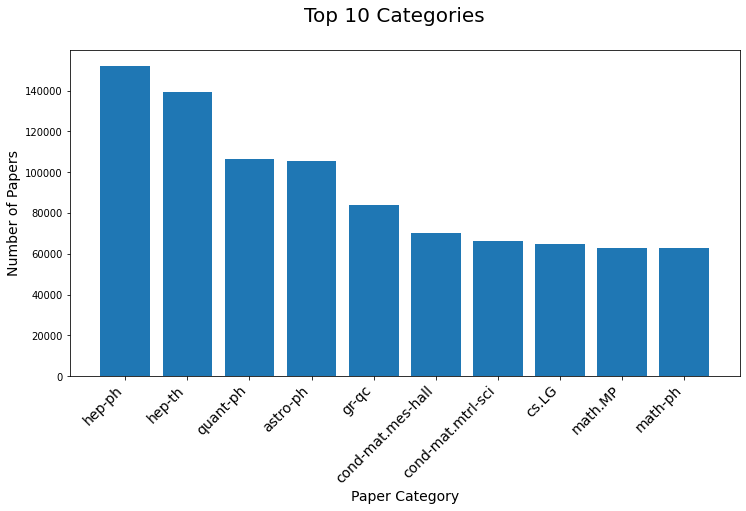

In [36]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
fig.suptitle('Top 10 Categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Paper Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[:10],counts[:10])
plt.show()


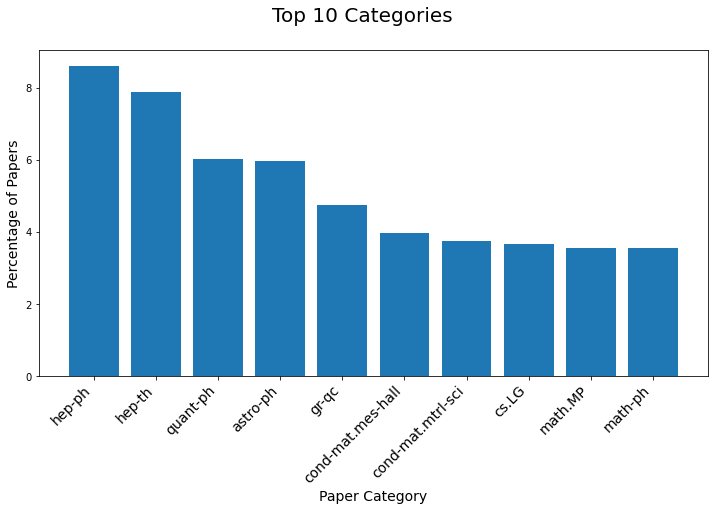

In [37]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
fig.suptitle('Top 10 Categories', fontsize=20)
plt.ylabel('Percentage of Papers', fontsize=14)
plt.xlabel('Paper Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[:10],((counts[:10]/df.shape[0])*100))
plt.show()

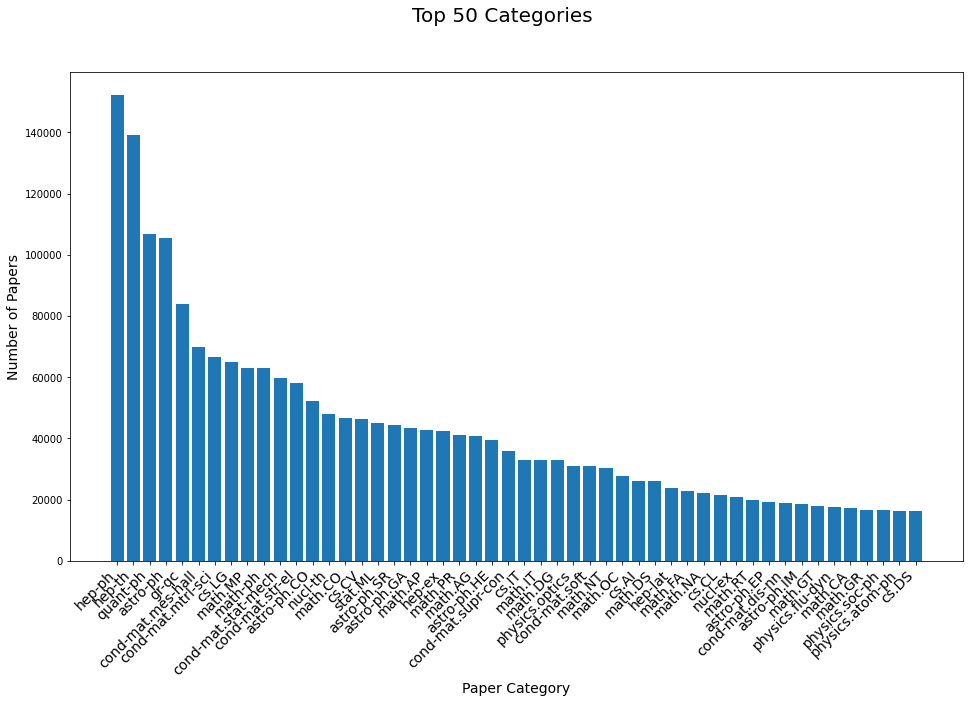

In [38]:
fig = plt.figure(figsize=(16, 9))
ax = fig.gca()
fig.suptitle('Top 50 Categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Paper Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[:50],counts[:50])
plt.show()


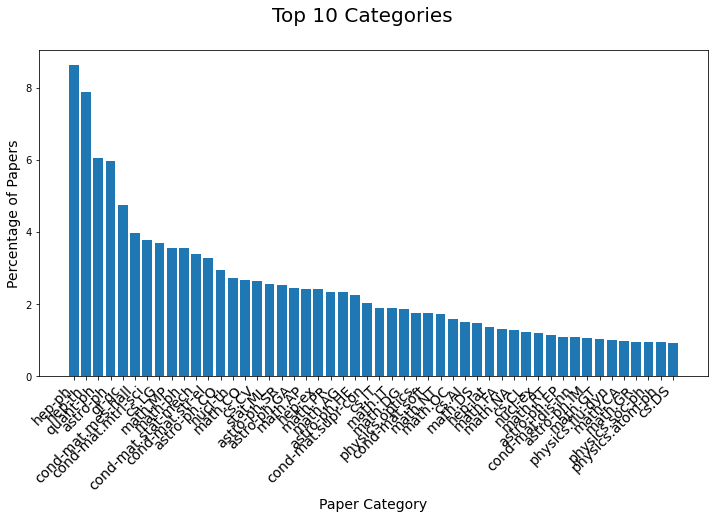

In [39]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
fig.suptitle('Top 10 Categories', fontsize=20)
plt.ylabel('Percentage of Papers', fontsize=14)
plt.xlabel('Paper Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[:50],((counts[:50]/df.shape[0])*100))
plt.show()

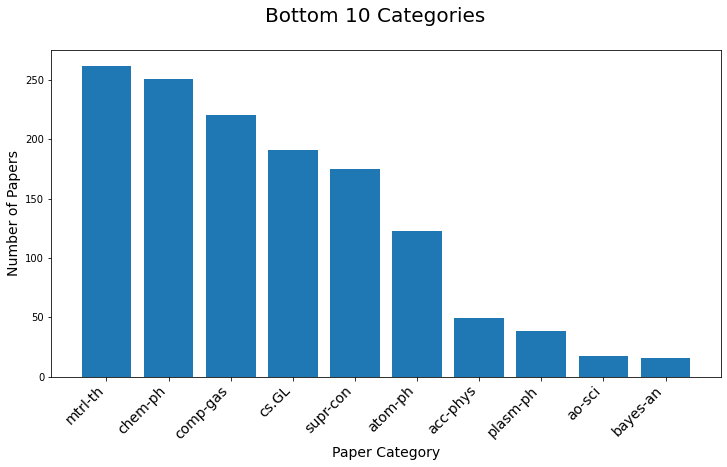

In [40]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
fig.suptitle('Bottom 10 Categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Paper Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[len(labels)-10:],counts[len(labels)-10:])
plt.show()

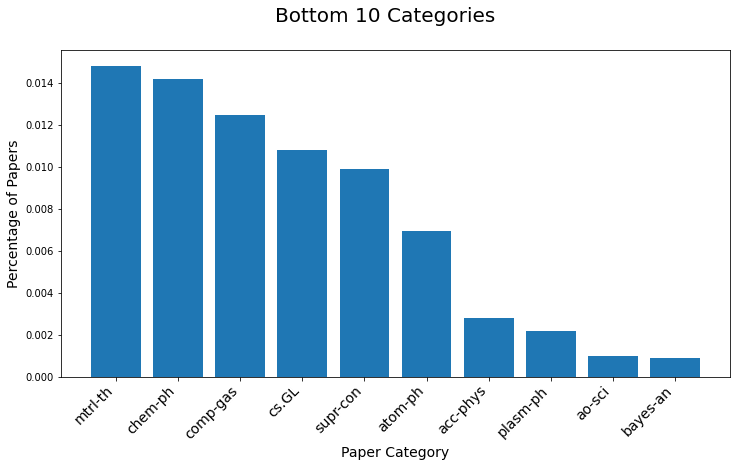

In [49]:
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
fig.suptitle('Bottom 10 Categories', fontsize=20)
plt.ylabel('Percentage of Papers', fontsize=14)
plt.xlabel('Paper Category', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
plt.bar(labels[len(labels)-10:],((counts[len(labels)-10:]/df.shape[0])*100))
plt.show()

In [30]:
multilabel_count=categories.sum(axis=1)

In [31]:
multilabel_counts = multilabel_count.value_counts()

In [32]:
df.shape

(1765688, 14)

In [33]:
multilabel_counts

1     1011620
2      491954
3      183101
4       59450
5       15575
6        3302
7         520
8         119
9          30
10         14
11          2
13          1
dtype: int64

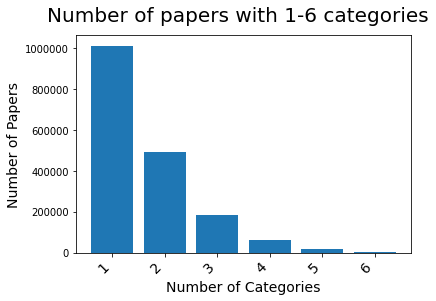

In [44]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
fig.suptitle('Number of papers with 1-6 categories', fontsize=20)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Number of Categories', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
ax.set_xticks(list(range(1,14)))
plt.bar(multilabel_counts.index[:6],multilabel_counts[:6].values)
plt.show()


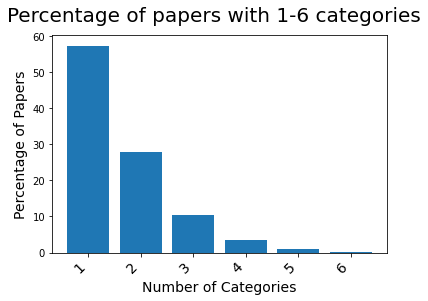

In [47]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
fig.suptitle('Percentage of papers with 1-6 categories', fontsize=20)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ylabel('Percentage of Papers', fontsize=14)
plt.xlabel('Number of Categories', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
ax.set_xticks(list(range(1,14)))
plt.bar(multilabel_counts.index[:6],(multilabel_counts[:6].values/df.shape[0])*100)
plt.show()

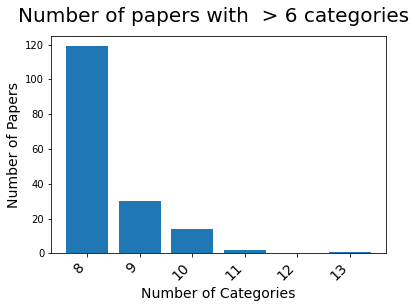

In [45]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
fig.suptitle('Number of papers with  > 6 categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Number of Categories', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
ax.set_xticks(list(range(1,14)))
plt.bar(multilabel_counts.index[7:],multilabel_counts[7:].values)
plt.show()

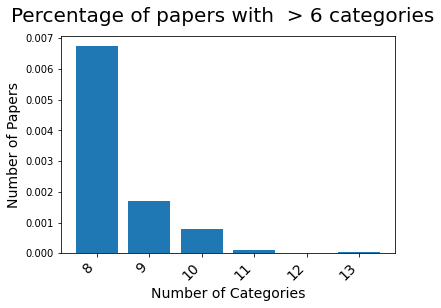

In [48]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
fig.suptitle('Percentage of papers with  > 6 categories', fontsize=20)
plt.ylabel('Number of Papers', fontsize=14)
plt.xlabel('Number of Categories', fontsize=14)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45, fontsize=14) # Specify a rotation for the tick labels 
ax.set_xticks(list(range(1,14)))
plt.bar(multilabel_counts.index[7:],(multilabel_counts[7:].values/df.shape[0])*100)
plt.show()

#Preprocessing for evaluation

## Stratified splitting of dataset

In [ ]:
df.head()

,id,submitter,title,journal_ref,doi,report_no,categories,license,abstract,abstract_vectorized,update_date,pages,figures,latest_version_date,latest_version,list_of_authors
0,704.0001,Pavel Nadolsky,Calculation of prompt diphoton production cros...,"Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,['hep-ph'],nan,A fully differential calculation in perturba...,"[-0.05816778168082237, -0.059670645743608475, ...",2008-11-26,37,15,"Tue, 24 Jul 2007 20:10:27 GMT",v2,"['Balázs C.', 'Berger E. L.', 'Nadolsky P. M.'..."
1,704.0002,Louis Theran,Sparsity-certifying Graph Decompositions,nan,nan,nan,"['math.CO', 'cs.CG']",http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[-0.04349585622549057, -0.04287387430667877, -...",2008-12-13,No data,No data,"Sat, 13 Dec 2008 17:26:00 GMT",v2,"['Streinu Ileana', 'Theran Louis']"
2,704.0003,Hongjun Pan,The evolution of the Earth-Moon system based o...,nan,nan,nan,['physics.gen-ph'],nan,The evolution of Earth-Moon system is descri...,"[-0.03236207738518715, -0.05997699126601219, -...",2008-01-13,23,3,"Sun, 13 Jan 2008 00:36:28 GMT",v3,['Pan Hongjun']
3,704.0004,David Callan,A determinant of Stirling cycle numbers counts...,nan,nan,nan,['math.CO'],nan,We show that a determinant of Stirling cycle...,"[-0.025674011558294296, -0.06982755661010742, ...",2007-05-23,11,No data,"Sat, 31 Mar 2007 03:16:14 GMT",v1,['Callan David']
4,704.0005,Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"Illinois J. Math. 52 (2008) no.2, 681-689",nan,nan,"['math.CA', 'math.FA']",nan,In this paper we show how to compute the $\L...,"[-0.07878756523132324, -0.08073261380195618, 0...",2013-10-15,No data,No data,"Mon, 2 Apr 2007 18:09:58 GMT",v1,"['Abu-Shammala Wael', 'Torchinsky Alberto']"


In [ ]:
df.shape

(100001, 16)

In [ ]:
df.columns

Index(['id', 'submitter', 'title', 'journal_ref', 'doi', 'report_no',
       'categories', 'license', 'abstract', 'abstract_vectorized',
       'update_date', 'pages', 'figures', 'latest_version_date',
       'latest_version', 'list_of_authors'],
      dtype='object')

In [ ]:
after_transformation = df[df.categories.map(df.categories.value_counts()) >= 2]

In [ ]:
y=after_transformation['categories']

In [ ]:
after_transformation_without_categories=after_transformation.drop( columns=['categories'])

In [ ]:
df.shape

(100001, 16)

In [ ]:
after_transformation_without_categories.shape

(96412, 15)

In [ ]:
y.shape

(96412,)

In [ ]:
df.categories.value_counts()

['astro-ph']                                              16291
['hep-ph']                                                 5322
['quant-ph']                                               4225
['hep-th']                                                 3702
['cond-mat.mtrl-sci']                                      2085
                                                          ...  
['math.CO', 'math.AC', 'math.RA']                             1
['q-bio.PE', 'math-ph', 'math.MP', 'q-bio.QM']                1
['cs.CR', 'cs.IR']                                            1
['cond-mat.stat-mech', 'physics.class-ph', 'quant-ph']        1
['physics.space-ph', 'physics.comp-ph']                       1
Name: categories, Length: 6072, dtype: int64

In [ ]:
y.value_counts()

['astro-ph']                                           16291
['hep-ph']                                              5322
['quant-ph']                                            4225
['hep-th']                                              3702
['cond-mat.mtrl-sci']                                   2085
                                                       ...  
['physics.plasm-ph', 'astro-ph', 'physics.flu-dyn']        2
['math.CV', 'math.AC', 'math.AG']                          2
['hep-th', 'astro-ph', 'hep-ph', 'nlin.PS']                2
['stat.AP', 'math.ST', 'stat.ME', 'stat.TH']               2
['physics.gen-ph', 'q-bio.PE']                             2
Name: categories, Length: 2483, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(after_transformation_without_categories, y, test_size=0.2, random_state=42,stratify= y)

In [ ]:
X_train['categories']=y_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test['categories']=y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test.columns

Index(['id', 'submitter', 'title', 'journal_ref', 'doi', 'report_no',
       'license', 'abstract', 'abstract_vectorized', 'update_date', 'pages',
       'figures', 'latest_version_date', 'latest_version', 'list_of_authors',
       'categories'],
      dtype='object')

In [ ]:
X_train.to_json('/content/drive/My Drive/ING/VINF/train_100k.json',orient="records")
X_test.to_json('/content/drive/My Drive/ING/VINF/test_100k.json',orient="records")

## Evaluation test

In [ ]:
df_eval=pd.read_json('/content/drive/My Drive/ING/VINF/evaluate_100k.json',orient='records')

In [ ]:
df_eval.head()

,id,submitter,title,journal_ref,doi,report_no,license,abstract,abstract_vectorized,update_date,pages,figures,latest_version_date,latest_version,list_of_authors,categories,most_similar_title_universal_sentence_encoder,most_similar_categories_universal_sentence_encoder,precision_universal_sentence_encoder,recall_universal_sentence_encoder,score_universal_sentence_encoder,precision_TFIDF,recall_TFIDF,score_TFIDF,most_similar_title_TFIDF,most_similar_categories_TFIDF
0,710.0314,Amina Zghiche,Charm Meson Spectroscopy at Babar and CLEO-C,"ECONF C070805:37,2007",nan,eConf#C070805,nan,In this mini-review we report on the most re...,"[-0.06770581752061844, 0.001342404866591096, -...",2011-06-15,No data,No data,"Mon, 15 Oct 2007 08:24:39 GMT",v2,['Zghiche A.'],['hep-ex'],Charm Meson Decays,"[hep-ph, hep-ex]",0.5,1.0,1.687578,0.0,0.0,8.925552,$\delta$ meson effects on neutron stars in the...,[nucl-th]
1,808.3997,Aurel Rascanu,Viability for stochastic differential equation...,nan,nan,nan,http://arxiv.org/licenses/nonexclusive-distrib...,In this paper we prove a viability result fo...,"[-0.04423050954937935, -0.07066845893859863, -...",2008-09-01,No data,No data,"Thu, 28 Aug 2008 21:06:47 GMT",v1,"['Ciotir Ioana', 'Rascanu Aurel']","['math.DS', 'math.CA']",Reflected Solutions of Backward Doubly Stochas...,[math.PR],0.0,0.0,1.742899,0.0,0.0,0.036042,Dynamics of non-harmonic internal gravity wave...,"[physics.flu-dyn, physics.ao-ph]"
2,803.0858,Oleg Verbitsky,Untangling planar graphs from a specified vert...,Discrete Applied Mathematics 159:8 (2011) 789-799,10.1016/j.dam.2011.01.011,nan,http://arxiv.org/licenses/nonexclusive-distrib...,"Given a planar graph $G$, we consider drawin...","[0.018981892615556717, -0.060920633375644684, ...",2011-05-20,18,4,"Tue, 23 Nov 2010 09:59:13 GMT",v5,"['Kang Mihyun', 'Pikhurko Oleg', 'Ravsky Alexa...","['cs.DM', 'cs.CG']",Untangling polygons and graphs,"[cs.CG, cs.DM]",1.0,1.0,1.746162,1.0,1.0,30.227854,Untangling a Planar Graph,"[cs.CG, cs.DM]"
3,809.4575,Giuseppe Vallone Dr.,Multi-path entanglement of two photons,"Phys. Rev. Lett. 102, 153902 (2009)",10.1103/PhysRevLett.102.153902,nan,http://arxiv.org/licenses/nonexclusive-distrib...,We present a novel optical device based on a...,"[-0.04593786597251892, -0.062123969197273254, ...",2009-04-27,4,3,"Mon, 23 Feb 2009 13:43:16 GMT",v3,"['Rossi A.', 'Vallone G.', 'Chiuri A.', 'De Ma...",['quant-ph'],Synthesis and Analysis of Entangled Photonic Q...,[quant-ph],1.0,1.0,1.768435,0.0,0.0,9.529106,Novel Bonding technologies for wafer-level tra...,[cs.OH]
4,708.1239,Nicola Cufaro Petroni,Selfdecomposability and selfsimilarity: a conc...,Physica A 387 (2008) 1875-94,10.1016/j.physa.2007.11.036,"Rapporto n. 32/07 - Dpt of Mathematics, Bari U...",nan,We summarize the relations among three class...,"[0.032743390649557114, -0.05095825716853142, 0...",2008-05-06,24,3,"Tue, 27 Nov 2007 22:03:31 GMT",v3,['Petroni Nicola Cufaro'],"['cond-mat.stat-mech', 'math.PR']",One-dimensional space-discrete transport subje...,"[math-ph, math.MP]",0.0,0.0,1.624572,0.0,0.0,0.758185,Study of the young stellar population of NGC 4...,[astro-ph]


In [ ]:
df_eval.columns

Index(['id', 'submitter', 'title', 'journal_ref', 'doi', 'report_no',
       'license', 'abstract', 'abstract_vectorized', 'update_date', 'pages',
       'figures', 'latest_version_date', 'latest_version', 'list_of_authors',
       'categories', 'most_similar_title_universal_sentence_encoder',
       'most_similar_categories_universal_sentence_encoder',
       'precision_universal_sentence_encoder',
       'recall_universal_sentence_encoder', 'score_universal_sentence_encoder',
       'precision_TFIDF', 'recall_TFIDF', 'score_TFIDF',
       'most_similar_title_TFIDF', 'most_similar_categories_TFIDF'],
      dtype='object')

In [ ]:
print("mean precision universal sentence encoder  {}".format(
   df_eval['precision_universal_sentence_encoder'].mean()))
print("mean recall universal sentence encoder {}".format(
    df_eval['recall_universal_sentence_encoder'].mean()))
print("---------------------------------------")
print("mean precision TFIDF  {}".format(
   df_eval['precision_TFIDF'].mean()))
print("mean recall TFIDF {}".format(
    df_eval['recall_TFIDF'].mean()))

mean precision universal sentence encoder  0.5714428944320555
mean recall universal sentence encoder 0.5774386765544787
---------------------------------------
mean precision TFIDF  0.43336012722778205
mean recall TFIDF 0.4354586941865882


In [ ]:
df_eval.sort_values(by=['score_universal_sentence_encoder','score_TFIDF'],ascending=False)[['title','categories','most_similar_categories_universal_sentence_encoder','most_similar_title_universal_sentence_encoder','most_similar_title_TFIDF']]

,title,categories,most_similar_categories_universal_sentence_encoder,most_similar_title_universal_sentence_encoder,most_similar_title_TFIDF
11845,"\""Uber Pro-p-Fundamentalgruppen markierter ari...",['math.NT'],[math.NT],On pro-p fundamental groups of marked arithmet...,On pro-p fundamental groups of marked arithmet...
12007,Parton distribution function uncertainties & n...,['hep-ph'],[hep-ph],Nuclear Parton Distribution Functions,Nuclear Parton Distribution Functions
7204,The Dynamical State of the Starless Dense Core...,['astro-ph'],[astro-ph],The Dynamical State fo the Starless Dense Core...,The Dynamical State fo the Starless Dense Core...
9173,Singlet fermionic dark matter,['hep-ph'],[hep-ph],Singlet fermionic dark matter as a natural hig...,Singlet fermionic dark matter as a natural hig...
13308,Codes Associated with Orthogonal Groups and Po...,"['math.NT', 'cs.IT', 'math.IT']","[math.NT, cs.IT, math.IT]","Codes Associated with $O^+(2n,2^r)$ and Power ...","Codes Associated with $O^+(2n,2^r)$ and Power ..."
...,...,...,...,...,...
11566,Discussion of: Statistical analysis of an arch...,['stat.AP'],,,
12768,Comment: Struggles with Survey Weighting and R...,['stat.ME'],,,
13041,Comment: The 2005 Neyman Lecture: Dynamic Inde...,['stat.ME'],,,
17832,Comment: Fisher Lecture: Dimension Reduction i...,['stat.ME'],,,


In [ ]:
df_eval.columns

Index(['id', 'submitter', 'title', 'journal_ref', 'doi', 'report_no',
       'license', 'abstract', 'abstract_vectorized', 'update_date', 'pages',
       'figures', 'latest_version_date', 'latest_version', 'list_of_authors',
       'categories', 'most_similar_title_universal_sentence_encoder',
       'most_similar_categories_universal_sentence_encoder',
       'precision_universal_sentence_encoder',
       'recall_universal_sentence_encoder', 'score_universal_sentence_encoder',
       'precision_TFIDF', 'recall_TFIDF', 'score_TFIDF',
       'most_similar_title_TFIDF', 'most_similar_categories_TFIDF'],
      dtype='object')

In [ ]:
df_eval[['title','categories','most_similar_title_universal_sentence_encoder','most_similar_categories_universal_sentence_encoder','precision_universal_sentence_encoder','recall_universal_sentence_encoder','score_universal_sentence_encoder','most_similar_title_TFIDF','most_similar_categories_TFIDF','precision_TFIDF','recall_TFIDF','score_TFIDF']].to_excel('/content/drive/My Drive/ING/VINF/evaluate_100k.xlsx')